In [38]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

In [39]:
import zipfile
import random
import pathlib
import collections
import cv2
import numpy as np
import tensorflow as tf
from tqdm import tqdm

def list_files_per_class(zip_path):
    """
    List the files in each class of the dataset given the zip path.

    Args:
        zip_path: Path to the local zip file. 

    Return:
        files: List of files in each of the classes.
    """
    files = []
    with zipfile.ZipFile(zip_path, 'r') as zip:
        for zip_info in zip.infolist():
            files.append(zip_info.filename)
    return files

def get_class(fname):
    """
    Retrieve the name of the class given a filename.

    Args:
        fname: Name of the file in the UCF101 dataset.

    Return:
        Class that the file belongs to.
    """
    return fname.split('_')[-3]

def get_files_per_class(files):
    """
    Retrieve the files that belong to each class. 

    Args:
        files: List of files in the dataset.

    Return:
        Dictionary of class names (key) and files (values).
    """
    files_for_class = collections.defaultdict(list)
    for fname in files:
        class_name = get_class(fname)
        files_for_class[class_name].append(fname)
    return files_for_class

def download_from_zip(zip_path, to_dir, file_names):
    """
    Download the contents of the zip file from the zip path.

    Args:
        zip_path: Local zip file path containing data.
        to_dir: Directory to download data to.
        file_names: Names of files to download.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip:
        for fn in tqdm(file_names):
            class_name = get_class(fn)
            zip.extract(fn, str(to_dir / class_name))
            unzipped_file = to_dir / class_name / fn

            fn = pathlib.Path(fn).parts[-1]
            output_file = to_dir / class_name / fn
            unzipped_file.rename(output_file)

def split_class_lists(files_for_class, count):
    """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
        files_for_class: Files belonging to a particular class of data.
        count: Number of files to download.

    Return:
        split_files: Files belonging to the subset of data.
        remainder: Dictionary of the remainder of files that need to be downloaded.
    """
    split_files = []
    remainder = {}
    for cls in files_for_class:
        split_files.extend(files_for_class[cls][:count])
        remainder[cls] = files_for_class[cls][count:]
    return split_files, remainder

def download_ufc_101_subset(zip_path, num_classes, splits, download_dir):
    """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
        zip_path: Local zip file path containing data.
        num_classes: Number of labels.
        splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
                (value is number of files per split).
        download_dir: Directory to download data to.

    Return:
        dir: Posix path of the resulting directories containing the splits of data.
    """
    files = list_files_per_class(zip_path)
    for f in files:
        tokens = f.split('/')
        if len(tokens) <= 2:
            files.remove(f) # Remove that item from the list if it does not have a filename
    
    files_for_class = get_files_per_class(files)

    classes = list(files_for_class.keys())[:num_classes]

    for cls in classes:
        new_files_for_class = files_for_class[cls]
        random.shuffle(new_files_for_class)
        files_for_class[cls] = new_files_for_class
        
    # Only use the number of classes you want in the dictionary
    files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

    dirs = {}
    for split_name, split_count in splits.items():
        print(split_name, ":")
        split_dir = download_dir / split_name
        split_files, files_for_class = split_class_lists(files_for_class, split_count)
        download_from_zip(zip_path, split_dir, split_files)
        dirs[split_name] = split_dir

    return dirs

def format_frames(frame, output_size):
    """
    Pad and resize an image from a video.
    
    Args:
        frame: Image that needs to resized and padded. 
        output_size: Pixel size of the output frame image.

    Return:
        Formatted frame with padding of specified output size.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=15):
    """
    Creates frames from each video file present for each category.

    Args:
        video_path: File path to the video.
        n_frames: Number of frames to be created per video file.
        output_size: Pixel size of the output frame image.

    Return:
        A NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

class FrameGenerator:
    def __init__(self, path, n_frames, training=False):
        """ Returns a set of frames with their associated label. 

        Args:
            path: Video file paths.
            n_frames: Number of frames. 
            training: Boolean to determine if training dataset is being created.
        """
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.avi'))
        classes = [p.parent.name for p in video_paths] 
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames) 
            label = self.class_ids_for_name[name] # Encode labels
            yield video_frames, label


In [40]:
# Change the zip file path to your local zip file path
zip_path = pathlib.Path('../data/local_video_action_dataset/CowActionNet.zip')
download_dir = pathlib.Path('./CowActionNet_subset/')
subset_paths = download_ufc_101_subset(zip_path, 
                      num_classes=5, 
                      splits={"train": 30, "val": 5, "test": 5},
                      download_dir=download_dir)

train :


100%|██████████| 150/150 [00:00<00:00, 2067.35it/s]


val :


100%|██████████| 25/25 [00:00<00:00, 1463.16it/s]


test :


100%|██████████| 25/25 [00:00<00:00, 1592.06it/s]


In [41]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)

# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

## Training model

In [42]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [43]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

In [44]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

In [45]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [46]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [47]:
class ResizeVideo(tf.keras.layers.Layer):
    def __init__(self, height, width):
        super().__init__()
        self.height = height
        self.width = width
        self.resizing_layer = layers.Resizing(self.height, self.width)

    def call(self, video):
        # Parse the input shape to ensure dynamic shapes are handled
        batch_size = tf.shape(video)[0]
        time_steps = tf.shape(video)[1]
        height = tf.shape(video)[2]
        width = tf.shape(video)[3]
        channels = tf.shape(video)[4]

        # Reshape video tensor to merge batch and time dimensions
        images = tf.reshape(video, (batch_size * time_steps, height, width, channels))
        
        # Resize images
        resized_images = self.resizing_layer(images)
        
        # Reshape back to the original dimensions with new height and width
        resized_video = tf.reshape(resized_images, (batch_size, time_steps, self.height, self.width, channels))
        
        return resized_video

In [48]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input
x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [49]:
frames, label = next(iter(train_ds))
model.build(frames)

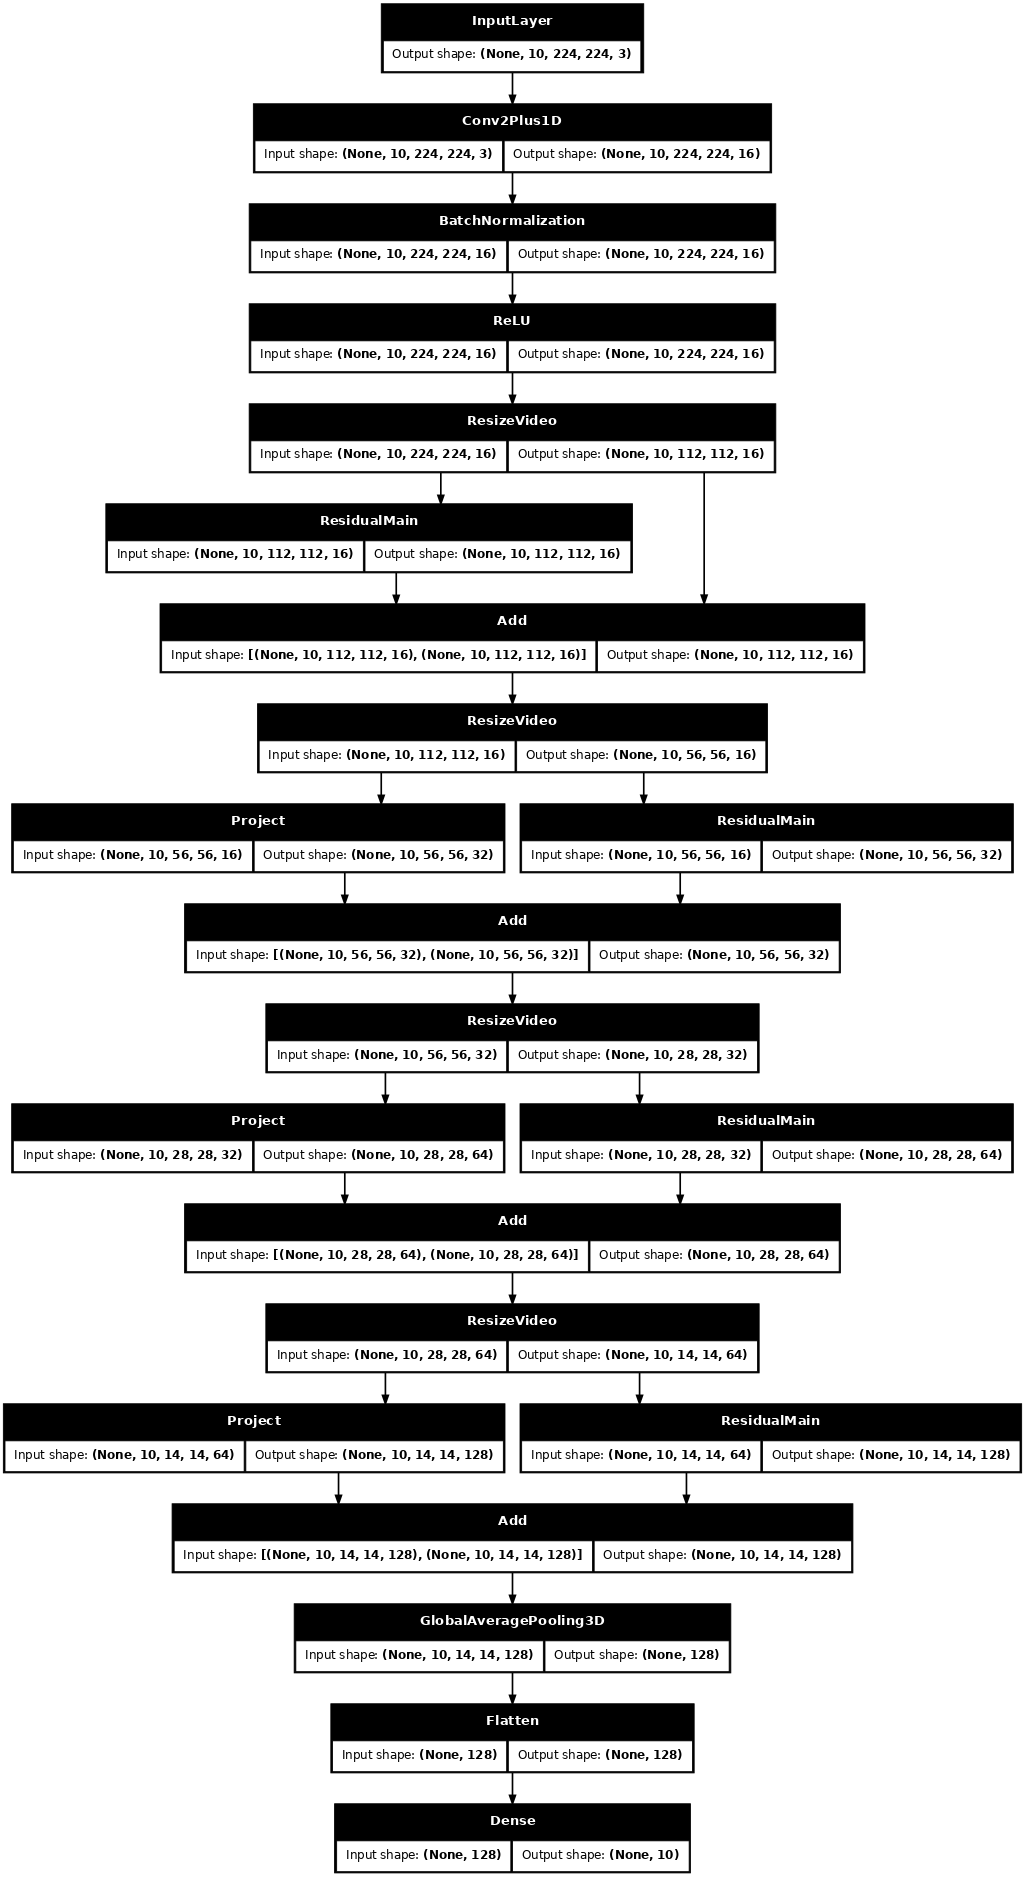

In [50]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [51]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [53]:
history = model.fit(x = train_ds,
                    epochs = 40, 
                    validation_data = val_ds)

# # Number of classes you're using
# num_classes = 5
# # Files per class for each dataset
# train_files_per_class = 30
# val_files_per_class = 10
# test_files_per_class = 10

# # Calculate the total number of samples for training and validation
# total_train_samples = num_classes * train_files_per_class
# total_val_samples = num_classes * val_files_per_class
# total_test_samples = num_classes * test_files_per_class

# # Batch size
# batch_size = 8

# # Calculate steps per epoch for training and validation
# steps_per_epoch = total_train_samples // batch_size
# validation_steps = total_val_samples // batch_size

# # Fit the model
# history = model.fit(
#     x = train_ds,
#     epochs = 10,
#     steps_per_epoch = steps_per_epoch,
#     validation_data = val_ds,
#     validation_steps = validation_steps
# )


Epoch 1/40
     19/Unknown 22s 1s/step - accuracy: 0.2833 - loss: 1.6382

2024-06-28 15:53:02.520739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/tvlaemynck/anaconda3/envs/myenv/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2818 - loss: 1.6378 - val_accuracy: 0.3600 - val_loss: 1.7388
Epoch 2/40


2024-06-28 15:53:05.654952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2005 - loss: 1.6317

2024-06-28 15:53:28.051247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2002 - loss: 1.6302 - val_accuracy: 0.3600 - val_loss: 1.6031
Epoch 3/40


2024-06-28 15:53:30.202568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2899 - loss: 1.4876

2024-06-28 15:53:52.531868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2894 - loss: 1.4913 - val_accuracy: 0.2000 - val_loss: 1.6815
Epoch 4/40


2024-06-28 15:53:54.745114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3230 - loss: 1.4063

2024-06-28 15:54:17.127973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3215 - loss: 1.4109 - val_accuracy: 0.2000 - val_loss: 1.6124
Epoch 5/40


2024-06-28 15:54:19.313473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3640 - loss: 1.4531

2024-06-28 15:54:41.603622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3621 - loss: 1.4537 - val_accuracy: 0.2000 - val_loss: 1.5329
Epoch 6/40


2024-06-28 15:54:43.837248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2601 - loss: 1.5051

2024-06-28 15:55:05.968930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2631 - loss: 1.5030 - val_accuracy: 0.2400 - val_loss: 1.5399
Epoch 7/40


2024-06-28 15:55:08.213988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3437 - loss: 1.4094

2024-06-28 15:55:30.754400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3442 - loss: 1.4110 - val_accuracy: 0.2400 - val_loss: 1.7375
Epoch 8/40


2024-06-28 15:55:32.890194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3463 - loss: 1.5237

2024-06-28 15:55:54.973417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3440 - loss: 1.5228 - val_accuracy: 0.2400 - val_loss: 1.5005
Epoch 9/40


2024-06-28 15:55:57.176470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3281 - loss: 1.5108

2024-06-28 15:56:19.369868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3300 - loss: 1.5082 - val_accuracy: 0.2800 - val_loss: 1.5606
Epoch 10/40


2024-06-28 15:56:21.575718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3729 - loss: 1.4859

2024-06-28 15:56:43.779431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3726 - loss: 1.4849 - val_accuracy: 0.2800 - val_loss: 1.5129
Epoch 11/40


2024-06-28 15:56:46.014703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3814 - loss: 1.4933

2024-06-28 15:57:08.194437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3807 - loss: 1.4930 - val_accuracy: 0.2800 - val_loss: 1.5667
Epoch 12/40


2024-06-28 15:57:10.466844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3729 - loss: 1.3804

2024-06-28 15:57:32.719364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3736 - loss: 1.3820 - val_accuracy: 0.3200 - val_loss: 1.4861
Epoch 13/40


2024-06-28 15:57:34.935961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2947 - loss: 1.4192

2024-06-28 15:57:57.199702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2979 - loss: 1.4190 - val_accuracy: 0.3600 - val_loss: 1.4475
Epoch 14/40


2024-06-28 15:57:59.358557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3650 - loss: 1.3739

2024-06-28 15:58:21.627733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3661 - loss: 1.3732 - val_accuracy: 0.2800 - val_loss: 1.5539
Epoch 15/40


2024-06-28 15:58:23.802225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3118 - loss: 1.3789

2024-06-28 15:58:46.010694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3138 - loss: 1.3775 - val_accuracy: 0.2400 - val_loss: 1.5801
Epoch 16/40


2024-06-28 15:58:48.286363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4145 - loss: 1.3914

2024-06-28 15:59:10.571603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4158 - loss: 1.3873 - val_accuracy: 0.1600 - val_loss: 1.7898
Epoch 17/40


2024-06-28 15:59:12.776996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3957 - loss: 1.3100

2024-06-28 15:59:35.134361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3960 - loss: 1.3102 - val_accuracy: 0.2400 - val_loss: 1.5646
Epoch 18/40


2024-06-28 15:59:37.291965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3827 - loss: 1.3031

2024-06-28 15:59:59.418178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3839 - loss: 1.3046 - val_accuracy: 0.2800 - val_loss: 1.4051
Epoch 19/40


2024-06-28 16:00:01.774401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3914 - loss: 1.2926

2024-06-28 16:00:23.711930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3928 - loss: 1.2919 - val_accuracy: 0.2400 - val_loss: 1.6328
Epoch 20/40


2024-06-28 16:00:25.925219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4019 - loss: 1.3670

2024-06-28 16:00:47.844564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3998 - loss: 1.3677 - val_accuracy: 0.3200 - val_loss: 1.6655
Epoch 21/40


2024-06-28 16:00:49.921159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4179 - loss: 1.2330

2024-06-28 16:01:11.995543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4177 - loss: 1.2363 - val_accuracy: 0.3200 - val_loss: 1.6207
Epoch 22/40


2024-06-28 16:01:14.265890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3724 - loss: 1.2990

2024-06-28 16:01:36.322221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3745 - loss: 1.2966 - val_accuracy: 0.4400 - val_loss: 1.3826
Epoch 23/40


2024-06-28 16:01:38.471109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5403 - loss: 1.1638

2024-06-28 16:02:00.516389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5379 - loss: 1.1658 - val_accuracy: 0.3200 - val_loss: 1.6113
Epoch 24/40


2024-06-28 16:02:02.617489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3860 - loss: 1.2725

2024-06-28 16:02:24.540832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3864 - loss: 1.2710 - val_accuracy: 0.3600 - val_loss: 1.3657
Epoch 25/40


2024-06-28 16:02:26.795097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3895 - loss: 1.2323

2024-06-28 16:02:48.787227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3920 - loss: 1.2295 - val_accuracy: 0.4000 - val_loss: 1.4951
Epoch 26/40


2024-06-28 16:02:50.899863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4848 - loss: 1.1176

2024-06-28 16:03:13.064171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4829 - loss: 1.1204 - val_accuracy: 0.4400 - val_loss: 1.5833
Epoch 27/40


2024-06-28 16:03:15.131628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5310 - loss: 1.1515

2024-06-28 16:03:37.448129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5312 - loss: 1.1512 - val_accuracy: 0.3600 - val_loss: 1.3703
Epoch 28/40


2024-06-28 16:03:39.597635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4783 - loss: 1.1203

2024-06-28 16:04:01.606987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4764 - loss: 1.1217 - val_accuracy: 0.4400 - val_loss: 1.3561
Epoch 29/40


2024-06-28 16:04:03.767670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5236 - loss: 1.1108

2024-06-28 16:04:25.795084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5211 - loss: 1.1153 - val_accuracy: 0.2400 - val_loss: 1.4529
Epoch 30/40


2024-06-28 16:04:27.937277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5327 - loss: 1.2034

2024-06-28 16:04:49.745748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5321 - loss: 1.2019 - val_accuracy: 0.2400 - val_loss: 1.3396
Epoch 31/40


2024-06-28 16:04:51.981020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5281 - loss: 1.1815

2024-06-28 16:05:14.079745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5300 - loss: 1.1802 - val_accuracy: 0.3200 - val_loss: 1.4392
Epoch 32/40


2024-06-28 16:05:16.260030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4509 - loss: 1.1854

2024-06-28 16:05:38.216276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4514 - loss: 1.1834 - val_accuracy: 0.4000 - val_loss: 1.3362
Epoch 33/40


2024-06-28 16:05:40.284768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5083 - loss: 1.1507

2024-06-28 16:06:02.372867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5062 - loss: 1.1501 - val_accuracy: 0.4000 - val_loss: 1.4228
Epoch 34/40


2024-06-28 16:06:04.660166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4772 - loss: 1.0892

2024-06-28 16:06:26.793465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4753 - loss: 1.0928 - val_accuracy: 0.3200 - val_loss: 1.3685
Epoch 35/40


2024-06-28 16:06:28.946106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5732 - loss: 1.0384

2024-06-28 16:06:51.117970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5712 - loss: 1.0395 - val_accuracy: 0.3600 - val_loss: 1.2594
Epoch 36/40


2024-06-28 16:06:53.314534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4725 - loss: 1.1532

2024-06-28 16:07:15.513381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4729 - loss: 1.1556 - val_accuracy: 0.4000 - val_loss: 1.3578
Epoch 37/40


2024-06-28 16:07:17.664465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5426 - loss: 0.9682

2024-06-28 16:07:39.872778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5395 - loss: 0.9743 - val_accuracy: 0.3200 - val_loss: 1.6206
Epoch 38/40


2024-06-28 16:07:42.024585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4093 - loss: 1.2701

2024-06-28 16:08:04.277486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4098 - loss: 1.2674 - val_accuracy: 0.2800 - val_loss: 1.3558
Epoch 39/40


2024-06-28 16:08:06.465356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5954 - loss: 1.0448

2024-06-28 16:08:28.553453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5957 - loss: 1.0460 - val_accuracy: 0.4400 - val_loss: 1.2861
Epoch 40/40


2024-06-28 16:08:30.801135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5118 - loss: 1.0665

2024-06-28 16:08:53.146925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5125 - loss: 1.0662 - val_accuracy: 0.4400 - val_loss: 1.4270


2024-06-28 16:08:55.332965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


## Visualize

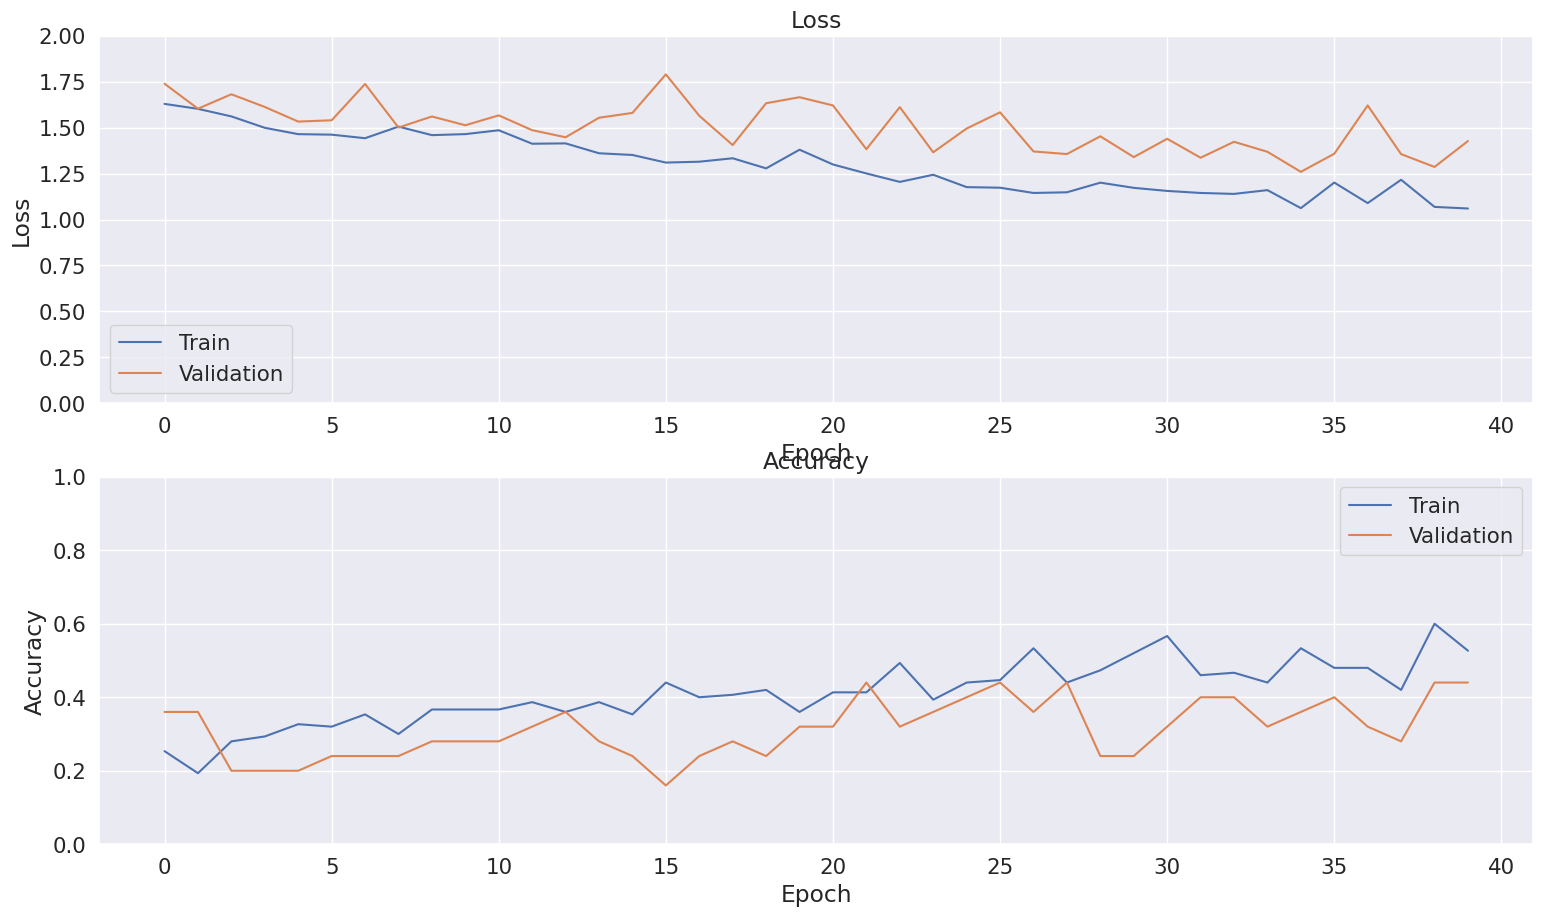

In [54]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## Evaluate

In [55]:
model.evaluate(test_ds, return_dict=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 0.3218 - loss: 1.5602


2024-06-28 16:09:03.137068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


{'accuracy': 0.4399999976158142, 'loss': 1.3728142976760864}

In [56]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [57]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

2024-06-28 16:09:13.211851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 610ms/step


2024-06-28 16:09:25.971154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


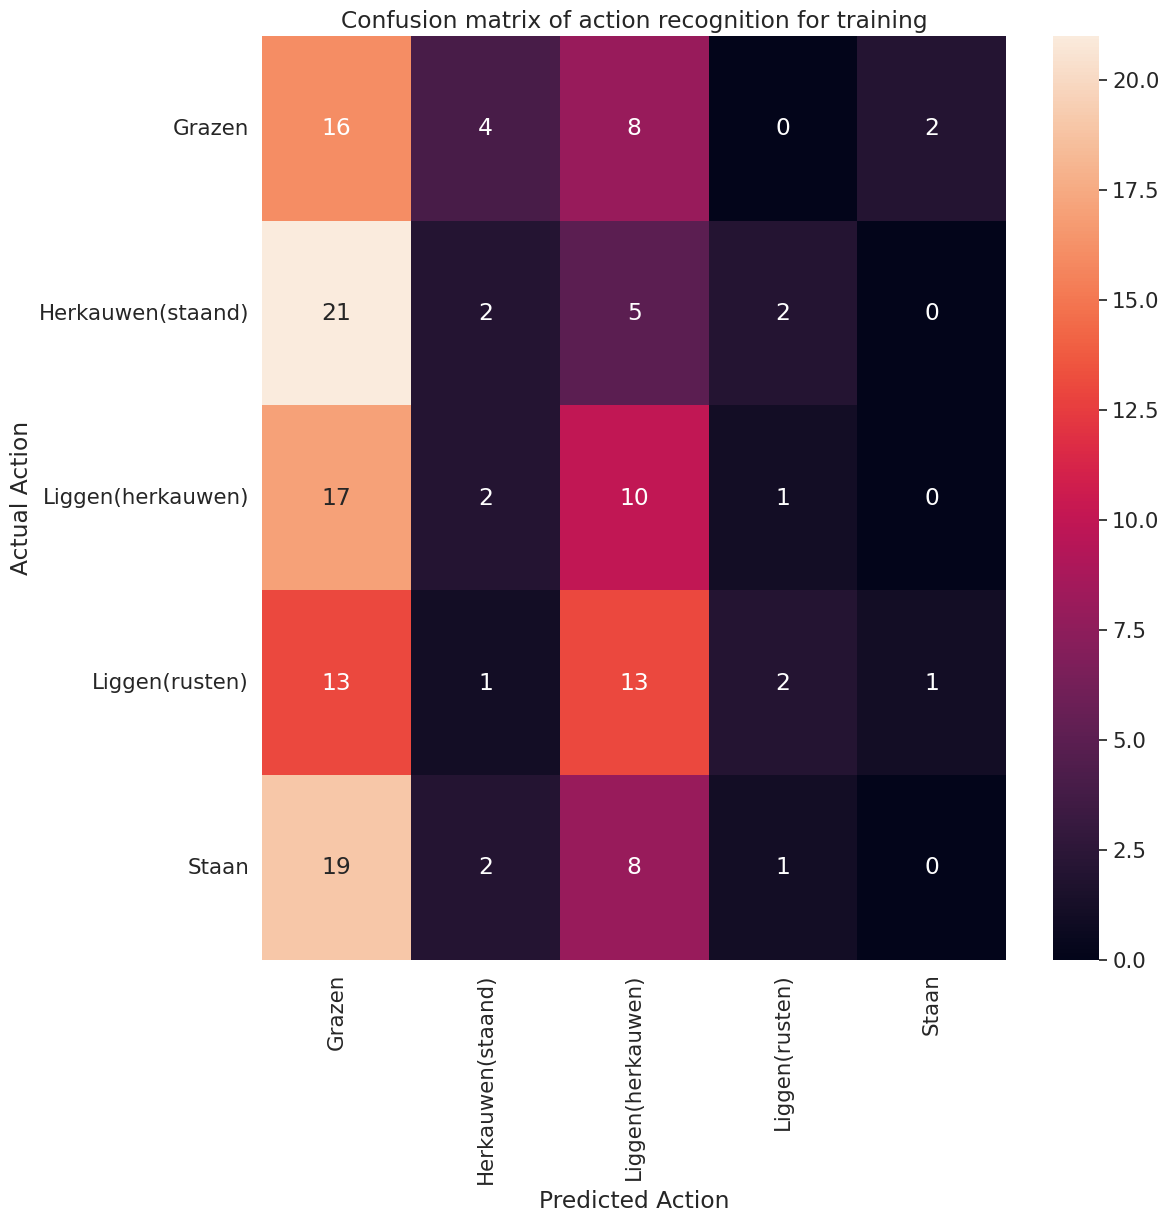

In [58]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

2024-06-28 16:09:28.428507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step


2024-06-28 16:09:30.636189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/tvlaemynck/anaconda3/envs/myenv/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


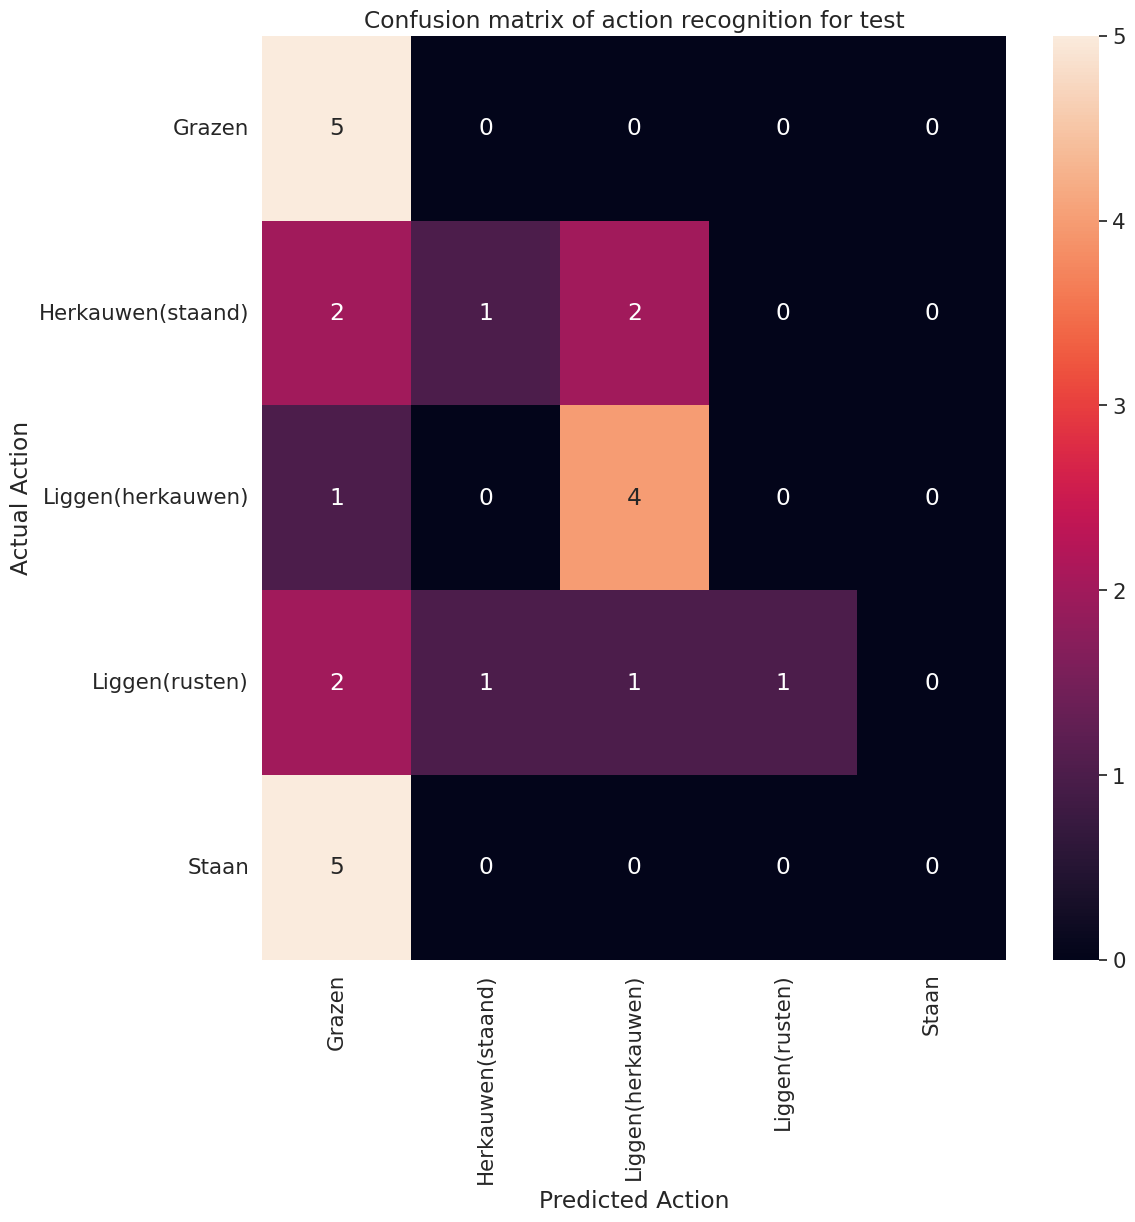

In [59]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [60]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [61]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

/tmp/ipykernel_1495488/791028922.py:25: RuntimeWarning: invalid value encountered in scalar divide
  precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision


In [62]:
precision

{'Grazen': 0.3333333333333333,
 'Herkauwen(staand)': 0.5,
 'Liggen(herkauwen)': 0.5714285714285714,
 'Liggen(rusten)': 1.0,
 'Staan': nan}

In [63]:
recall

{'Grazen': 1.0,
 'Herkauwen(staand)': 0.2,
 'Liggen(herkauwen)': 0.8,
 'Liggen(rusten)': 0.2,
 'Staan': 0.0}

In [64]:
model.save('video_model.keras')